In [1]:
# Importing (using/include) packages and files needed for the code to run 
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")
include("GridOperations.jl")

# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

In [2]:
struct Materials
    # 1 - subsurface global ocean
    # 2 - icy shell
    # 3 - sticky air
    alpha::Vector{Float64}
    rho0::Vector{Float64}
    Hr::Vector{Float64}
    Cp::Vector{Float64}
    kThermal::Vector{Float64}
    eta::Vector{Float64}
    function Materials()
        new([0.0,0.0,0.0],[1000.0,920.0,1.0],[0.0,0.0,0.0],[4180.0,2100,1e6],[0.5610,2.22,0.024],[1e12,1e15,1e17])
    end    
end


function initial_ice_depth(x::Float64)
    return 0.1*90000.0*sin(x*(2*pi/90000.0))+0.5*90000.0
end

function initial_surface_depth(x::Float64)
     return 3e4
end

# # Creating a function to assign viscosity if eta is not constant
# function compute_variable_eta(markers::Markers,materials::Materials)
#     t_icy = zeros(1,markers.nmark)
#     eta_i = zeros(1,markers.nmark)
#     for i in 1:markers.nmark
#         mx = markers.x[1,i]
#         my = markers.x[2,i]
#         h = initial_ice_depth(mx)
#         hsurf = initial_surface_depth(mx)
#         if my < h
#             t_icy[i] = 100.0+((273.0-100.0)/(h-hsurf))*(my-hsurf)
#             eta_i[i] = (1e15)*exp((Q*(273.0-t_icy[i]))/(R_cont*(273.0*t_icy[i])))
#         end
#     end 
#     return t_icy,eta_i
# end

function ice_viscosity(T::Float64)
    Q = 40000.0 # Activation Enegry
    R_cont = 8.314 # Gas Constant 
    return (1e15)*exp((Q*(273.0-T))/(R_cont*(273.0*T)))
end

function update_marker_viscosity!(markers::Markers,materials::Materials)
    eta = markers.scalarFields["eta"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        if mmat[i] == 2
            markers.scalars[eta,i] = ice_viscosity( markers.scalars[T,i] )
        end
    end
end


function update_marker_density!(markers::Markers,materials::Materials)
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark                
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
    end
end

function initial_conditions!(markers::Markers,materials::Materials)
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx)
        hsurf = initial_surface_depth(mx)
        if my > hice
             # subsurface global ocean
             markers.integers[material,i] = 1
             markers.scalars[T,i] = 273.0
             markers.scalars[eta,i] = materials.eta[1]
             markers.scalars[alpha,i] = materials.alpha[1]        
             markers.scalars[Cp,i] = materials.Cp[1]
        elseif my > hsurf
             # icy shell
             markers.integers[material,i] = 2
             markers.scalars[T,i] = 100.0+((273.0-100.0)/(hice-hsurf))*(my-hsurf)
#              markers.scalars[eta,i] = eta_i[i]
             markers.scalars[alpha,i] = materials.alpha[2]
             markers.scalars[Cp,i] = materials.Cp[2]            
        else
            # sticky air
            markers.integers[material,i] = 3
            markers.scalars[T,i] = 100.0            
            markers.scalars[eta,i] = materials.eta[3]
            markers.scalars[alpha,i] = materials.alpha[3]  
            markers.scalars[Cp,i] = materials.Cp[3]            
        end
    end # end loop over markers
    update_marker_viscosity!(markers,materials)
    update_marker_density!(markers,materials)
end

initial_conditions! (generic function with 1 method)

In [3]:
#function run(nstep::Int64)
    nstep=200

    nx = 101
    ny = 101
    W = 90000.0
    H = 90000.0
    gx = 0.0
    gy = 1.3

    Tbcval = [0.0,0.0,100.0,273.0]
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    materials = Materials()
    
    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","T","entropy","rho","eta","Cp"],["material"] ; nmx=markx,nmy=marky,random=false)
    println("Initial condition...")
    @time initial_conditions!(markers, materials)

    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 3.0 .*ones(grid.ny,grid.nx);
    Cp_c = 1250. .* ones(grid.ny+1,grid.nx+1);
    H = zeros(grid.ny,grid.nx);
    H = zeros(grid.ny,grid.nx);
    # fill!(rho,3200.);
    # fill!(kThermal,3.0);
    # fill!(Cp,1000.);

    time = 0.0
    iout=0
    last_plot = 0.0

    #     local rho
    #     local eta_s
    #     local T
    #     local dt
    #     local dTmax
    #     local dTemp
    #     local Tnew
    #     local Tlast
    
    rho = nothing
    rho_c = nothing
    Cp_c = nothing
    eta_s = nothing
    eta_n = nothing
    alpha = nothing
    vxc = nothing
    vyc = nothing
    shear_heating = nothing
    vx = nothing
    vy = nothing
    rho_vx = nothing
    rho_vy = nothing
    Tlast = nothing
    Tnew = nothing
    dt = dtmax

    output_dir = "test"
    for itime in 1:nstep
        # 0. update the viscosity and the density on the markers
        update_marker_viscosity!(markers,materials)
        # 1. Transfer properties markers -> nodes
        # 1a. Basic Nodes
        eta_s_new, = marker_to_basic_node(markers,grid,["eta",]);
        # 1b. Cell Centers
        rho_c_new,alpha_new,eta_n_new,Tlast_new,Cp_c_new = marker_to_cell_center(markers,grid,["rho","alpha","eta","T","Cp"])
        # 1c. Vx and Vy nodes:
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy")
        
        # deal with any NaN values from interpolation:
        if itime > 1
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(eta_n,eta_n_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
        end
        # Copy field data 
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        rho_c = copy(rho_c_new)
        alpha = copy(alpha_new)
        eta_s = copy(eta_s_new)
        eta_n = copy(eta_n_new)
        Tlast = copy(Tlast_new)
        Cp_c = copy(Cp_c_new)
    
        # 2. Assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy,dt=dt)
        stokes_solution = L\R
        vx,vy,P = unpack(stokes_solution,grid;ghost=true)
    
        # Get the velocity at the cell centers:
        vxc,vyc = velocity_to_centers(grid,vx,vy)
    
        # 3. Compute the advection timestep:
        if itime > 1
            this_dtmax = min(1.5*dt,dtmax)
        else
            this_dtmax = dtmax
        end
        dt = compute_timestep(grid,vxc,vyc ; dtmax=this_dtmax)

        dTmax = Inf
        dTemp = nothing
        Tnew = nothing
        for titer=1:2
        #while dTmax >= 10.0 # limit maximum temperature change
            # assemble and solve the energy equation
            println("Trying with timestep ",dt)
            L,R = assemble_energy_equation_center(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbcval);
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbcval);

            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))
            if dTmax > 10.0
               println("dTmax=",dTmax," dt=",dt)
               dt = min(dt,dTmax < 20.0 ? dt : dt*10.0/dTmax)
            else
               break
            end
        end

        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp_c[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node
        # dT_remaining = dTemp
        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")

        if time == 0.0 || time - last_plot >= plot_interval
            last_plot = time 
            name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
            vn = velocity_to_basic_nodes(grid,vxc,vyc)

        visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
            name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
            visualization(markers,time/seconds_in_year;filename=name)
            iout += 1
        end

        
        print(minimum(vyc)," ",maximum(vyc))
        move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
        time += dt
        println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr")
    end
# end
# @time run(1)


figure()
scatter(markers.x[1,:],markers.x[2,:],c="b",s=0.1)
show()

Creating Markers...
  0.123945 seconds (152.08 k allocations: 41.491 MiB, 5.70% gc time, 84.38% compilation time)
Initial condition...
  0.210442 seconds (1.63 M allocations: 29.250 MiB, 31.44% compilation time: 23% of which was recompilation)


LoadError: UndefVarError: marker_to_basic_node not defined

In [4]:
plot(T)

LoadError: UndefVarError: T not defined

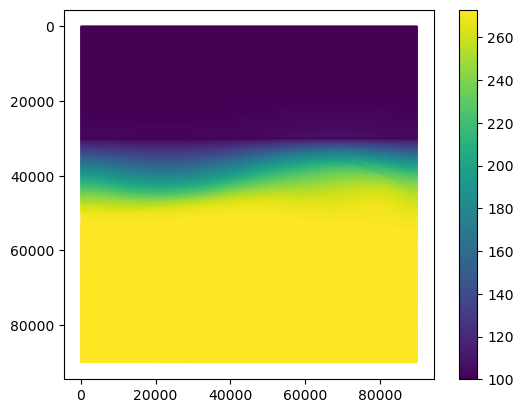

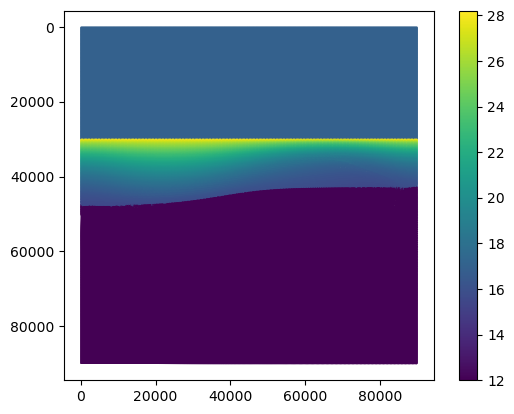

In [10]:
figure()
scatter(markers.x[1,:],markers.x[2,:],c=markers.scalars[markers.scalarFields["T"],:],s=0.1)
colorbar()
gca().invert_yaxis()
gca().set_aspect("equal")
show()

figure()
scatter(markers.x[1,:],markers.x[2,:],c=log10.(markers.scalars[markers.scalarFields["eta"],:]),s=0.1)
colorbar()
gca().invert_yaxis()
gca().set_aspect("equal")
show()

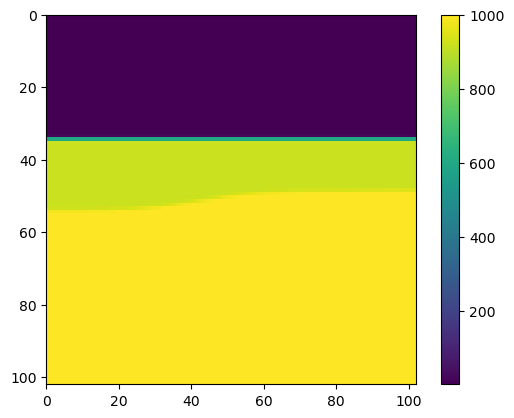

In [13]:
figure()
# pcolor(grid.xc,grid.yc,vxc)
pcolor(rho_c)
colorbar()
gca().invert_yaxis()
gca().set_aspect("equal")
show()

In [12]:
time/seconds_in_year


321885.973553743